In [3]:
!pip install selenium
!pip install webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 32.1 MB/s eta 0:00:00


In [10]:
import numpy as np

### Real time selenium based script for 1 bhk flat data extraction in Bangalore from magicbricks website

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_text(element):
    if element:
        return element.get_text(strip=True)
    return "N/A"

# URL for flats in Bangalore
BASE_URL = "https://www.magicbricks.com/property-for-sale/residential-real-estate?bedroom=1&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=Bangalore"

# Setup browser
opts = Options()
opts.add_argument("--headless")
opts.add_argument("--no-sandbox")
opts.add_argument("--disable-dev-shm-usage")
opts.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")

driver = webdriver.Chrome(options=opts)

all_rows = []
page = 1

try:
    while True:
        # Build URL with page number
        if page == 1:
            url = BASE_URL
        else:
            url = BASE_URL + "&page=" + str(page)

        print("\n--- Scraping Page " + str(page) + " ---")
        print("URL: " + url)

        driver.get(url)
        time.sleep(8)

        # Scroll to load all properties on current page
        print("Scrolling to load properties...")
        last_height = driver.execute_script("return document.body.scrollHeight")

        scroll_attempts = 0
        while scroll_attempts < 5:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(3)

            new_height = driver.execute_script("return document.body.scrollHeight")

            if new_height == last_height:
                break

            last_height = new_height
            scroll_attempts = scroll_attempts + 1

        time.sleep(2)

        soup = BeautifulSoup(driver.page_source, "lxml")
        cards = soup.select("div.mb-srp__card")

        print("Found " + str(len(cards)) + " property cards on this page")

        # If no cards found, we've reached the end
        if len(cards) == 0:
            print("No more properties found. Stopping.")
            break

        # Extract data from each card
        for idx, card in enumerate(cards, 1):
            try:
                # Extract BHK
                bhk_elem = card.select_one("span.mb-srp__card--highlight")
                bhk = get_text(bhk_elem)

                # Extract title
                title_elem = card.select_one("h2.mb-srp__card--title")
                title = get_text(title_elem)

                # Extract locality
                locality_elem = card.select_one("span.mb-srp__card__ads--location__link")
                locality = get_text(locality_elem)

                # Extract amount
                amount_elem = card.select_one("div.mb-srp__card__price--amount")
                amount = get_text(amount_elem)

                # Extract floor
                floor = "N/A"
                floor_elem = card.select_one("div.mb-srp__card__summary__list")
                if floor_elem:
                    floor_text = get_text(floor_elem)
                    if "Floor" in floor_text:
                        parts = floor_text.split("|")
                        for part in parts:
                            if "Floor" in part:
                                floor = part.strip()
                                break

                # Extract status
                status = "N/A"
                summary = card.select_one("div.mb-srp__card__summary__list")
                if summary:
                    summary_text = get_text(summary)
                    if "Ready to Move" in summary_text:
                        status = "Ready to Move"
                    elif "Under Construction" in summary_text:
                        status = "Under Construction"

                # Extract builder name
                builder_elem = card.select_one("span.mb-srp__card__ads--name")
                builder_name = get_text(builder_elem)

                all_rows.append({
                    "Page": page,
                    "BHK": bhk,
                    "Title": title,
                    "Locality": locality,
                    "Amount": amount,
                    "Floor": floor,
                    "Status": status,
                    "Builder_Name": builder_name
                })

            except Exception as e:
                print("Error on card " + str(idx) + ": " + str(e))
                continue

        print("Processed " + str(len(cards)) + " properties from page " + str(page))
        print("Total properties so far: " + str(len(all_rows)))

        # Move to next page
        page = page + 1

        # Add delay between pages
        time.sleep(3)

        # Safety limit - stop after 100 pages (or adjust as needed)
        if page > 10:
            print("\nReached page limit. Stopping.")
            break

except Exception as e:
    print(f"An error occurred during scraping: {e}")

finally:
    driver.quit()

# Create DataFrame
df = pd.DataFrame(all_rows)



--- Scraping Page 1 ---
URL: https://www.magicbricks.com/property-for-sale/residential-real-estate?bedroom=1&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=Bangalore
Scrolling to load properties...
Found 330 property cards on this page
Processed 330 properties from page 1
Total properties so far: 330

--- Scraping Page 2 ---
URL: https://www.magicbricks.com/property-for-sale/residential-real-estate?bedroom=1&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=Bangalore&page=2
Scrolling to load properties...
Found 330 property cards on this page
Processed 330 properties from page 2
Total properties so far: 660

--- Scraping Page 3 ---
URL: https://www.magicbricks.com/property-for-sale/residential-real-estate?bedroom=1&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=Bangalore&page=3
Scrolling to load properties...
Found 330 property cards on this page
Processed 3

### DataFrame formation

In [186]:
df = pd.DataFrame(all_rows)



In [187]:
df.duplicated()
df.drop_duplicates(inplace=True)  # Modifies original dataframe

### BHK extration from the Title column

In [189]:
def function(text):
    if isinstance(text, str):
        text = text.split()[0]  # Remove str() conversion
    return text

df["BHK"] = df["Title"].apply(function)
df.head(4)

,Page,BHK,Title,Locality,Amount,Floor,Status,Builder_Name
0,1,1,"1 BHK Flat for Sale in Hosa Road, off Hosur R...",N/A,₹79 Lac,N/A,Under Construction,N/A
1,1,1,"1 BHK Flat for Sale in Tumkur Road, Bangalore",N/A,₹76 Lac,Carpet Area422 sqftStatusReady to MoveFloor17 ...,Ready to Move,N/A
2,1,1,"1 BHK Flat for Sale in Carmelaram, Bangalore",N/A,₹63 Lac,Carpet Area412 sqftStatusReady to MoveFloor2 o...,Ready to Move,N/A
3,1,1,"1 BHK Flat for Sale in Begur Road, Bangalore",N/A,₹79.8 Lac,N/A,Ready to Move,N/A


###  Extraction of location from title

In [191]:

df["Locality"] = df["Title"].str.split(" in ").str[1].str.split(",").str[0]
df.head(5)

,Page,BHK,Title,Locality,Amount,Floor,Status,Builder_Name
0,1,1,"1 BHK Flat for Sale in Hosa Road, off Hosur R...",Hosa Road,₹79 Lac,N/A,Under Construction,N/A
1,1,1,"1 BHK Flat for Sale in Tumkur Road, Bangalore",Tumkur Road,₹76 Lac,Carpet Area422 sqftStatusReady to MoveFloor17 ...,Ready to Move,N/A
2,1,1,"1 BHK Flat for Sale in Carmelaram, Bangalore",Carmelaram,₹63 Lac,Carpet Area412 sqftStatusReady to MoveFloor2 o...,Ready to Move,N/A
3,1,1,"1 BHK Flat for Sale in Begur Road, Bangalore",Begur Road,₹79.8 Lac,N/A,Ready to Move,N/A
4,1,1,"1 BHK Flat for Sale in Rachenahalli, Thanisan...",Rachenahalli,₹90.5 Lac,Super Area715 sqftUnder ConstructionPoss. by D...,Under Construction,N/A


### Converting N/A to NaN for easy calculation

In [192]:
# Only process text columns
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].replace("N/A", np.nan)

df.head(4)


/tmp/ipython-input-3650720357.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace("N/A", np.nan)


,Page,BHK,Title,Locality,Amount,Floor,Status,Builder_Name
0,1,1,"1 BHK Flat for Sale in Hosa Road, off Hosur R...",Hosa Road,₹79 Lac,NaN,Under Construction,NaN
1,1,1,"1 BHK Flat for Sale in Tumkur Road, Bangalore",Tumkur Road,₹76 Lac,Carpet Area422 sqftStatusReady to MoveFloor17 ...,Ready to Move,NaN
2,1,1,"1 BHK Flat for Sale in Carmelaram, Bangalore",Carmelaram,₹63 Lac,Carpet Area412 sqftStatusReady to MoveFloor2 o...,Ready to Move,NaN
3,1,1,"1 BHK Flat for Sale in Begur Road, Bangalore",Begur Road,₹79.8 Lac,NaN,Ready to Move,NaN


### Area extraction from the floor column text

In [193]:
def area(text):
  if isinstance(text, str):
    text=text.split()[1]
  return text
df["Area"]=df["Floor"].apply(area)
df["Area"]

,Area
0,NaN
1,Area422
2,Area412
3,NaN
4,Area715
...,...
3294,Area510
3295,NaN
3297,Area680
3298,Area422


In [194]:
df["Area_sqft"] = df["Area"].str.replace("Area", "").str.strip()
df["Area_sqft"] = pd.to_numeric(df["Area_sqft"], errors='coerce')

# Drop rows where Area_sqft is NaN
df = df.dropna(subset=['Area_sqft'])
df["Area_sqft"] = df["Area_sqft"].astype(int)

df["Area_sqft"]

/tmp/ipython-input-1021536751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Area_sqft"] = df["Area_sqft"].astype(int)


,Area_sqft
1,422
2,412
4,715
7,650
11,430
...,...
3293,659
3294,510
3297,680
3298,422


### removing not known column

In [195]:
df.drop(columns=["Builder_Name"], inplace=True)
df.head(2)


/tmp/ipython-input-1349511065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Builder_Name"], inplace=True)


,Page,BHK,Title,Locality,Amount,Floor,Status,Area,Area_sqft
1,1,1,"1 BHK Flat for Sale in Tumkur Road, Bangalore",Tumkur Road,₹76 Lac,Carpet Area422 sqftStatusReady to MoveFloor17 ...,Ready to Move,Area422,422
2,1,1,"1 BHK Flat for Sale in Carmelaram, Bangalore",Carmelaram,₹63 Lac,Carpet Area412 sqftStatusReady to MoveFloor2 o...,Ready to Move,Area412,412


In [196]:
def convert_amount(text):
    if isinstance(text, str):
        # Remove ₹ symbol and spaces
        text = text.replace('₹', '').strip()

        # Extract the number (everything before Lac/Cr)
        number = float(text.split()[0])

        # Check unit and multiply
        if 'Lac' in text:
            return number * 100000
        elif 'Cr' in text:
            return number * 10000000
        else:
            return number
    return None

df["Amount"] = df["Amount"].apply(convert_amount)
df["Amount"]

/tmp/ipython-input-3132291866.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount"] = df["Amount"].apply(convert_amount)


,Amount
1,7600000.0
2,6300000.0
4,9050000.0
7,4100000.0
11,550000.0
...,...
3293,4090000.0
3294,2600000.0
3297,9000000.0
3298,9500000.0


### removing NaN values

In [197]:
df.dropna(inplace=True)
df

/tmp/ipython-input-955798070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,Page,BHK,Title,Locality,Amount,Floor,Status,Area,Area_sqft
1,1,1,"1 BHK Flat for Sale in Tumkur Road, Bangalore",Tumkur Road,7600000.0,Carpet Area422 sqftStatusReady to MoveFloor17 ...,Ready to Move,Area422,422
2,1,1,"1 BHK Flat for Sale in Carmelaram, Bangalore",Carmelaram,6300000.0,Carpet Area412 sqftStatusReady to MoveFloor2 o...,Ready to Move,Area412,412
4,1,1,"1 BHK Flat for Sale in Rachenahalli, Thanisan...",Rachenahalli,9050000.0,Super Area715 sqftUnder ConstructionPoss. by D...,Under Construction,Area715,715
7,1,1,"1 BHK Flat for Sale in Abbigere, Bangalore",Abbigere,4100000.0,Carpet Area650 sqftStatusReady to MoveFloor5 o...,Ready to Move,Area650,650
11,1,1,"1 BHK Flat for Sale in Kengeri, Bangalore",Kengeri,550000.0,Super Area430 sqftStatusReady to MoveFloorGrou...,Ready to Move,Area430,430
...,...,...,...,...,...,...,...,...,...
3293,10,1,1 BHK Apartment for Sale in Phase 1 Electronic...,Phase 1 Electronics City Bangalore,4090000.0,Super Area659 sqftStatusReady to MoveFloor2 ou...,Ready to Move,Area659,659
3294,10,1,1 BHK Builder Floor for Sale in Kodipalya Bang...,Kodipalya Bangalore,2600000.0,Super Area510 sqftStatusReady to MoveFloorGrou...,Ready to Move,Area510,510
3297,10,1,1 BHK Apartment for Sale in Panathur Bangalore,Panathur Bangalore,9000000.0,Super Area680 sqftStatusReady to MoveFloor15 o...,Ready to Move,Area680,680
3298,10,1,1 BHK Apartment for Sale in Panathur Main Road...,Panathur Main Road Bangalore,9500000.0,Carpet Area422 sqftStatusReady to MoveFloor7 o...,Ready to Move,Area422,422


### Cleaned data stored in excel file

In [198]:
df.to_excel("1bhk_bengalore.xlsx", index=False)

### Data Visualization

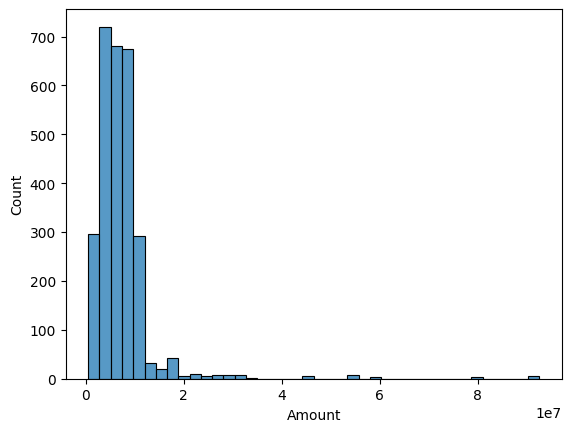

In [199]:
sns.histplot(x=df["Amount"], bins=40)
plt.show()

In [202]:
round(df["Amount"].median(),2)   # median 6500000.0
round(df["Amount"].mode()[0],2)  #mode 3000000.0
round(df["Amount"].mean(),2)    # mean 7330095.51

np.float64(7330095.51)

### Distribution of Amount and Area

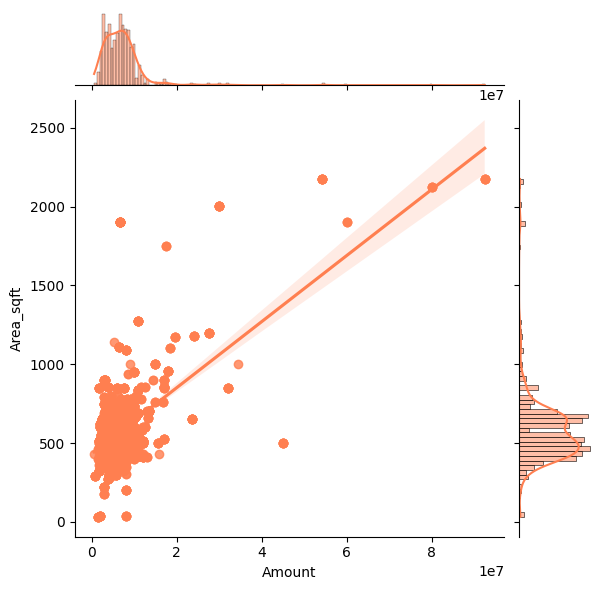

In [208]:
sns.jointplot(data=df, x="Amount", y="Area_sqft", kind="reg", color="coral")
plt.show()

### Top 5 common locality

In [203]:
df["Locality"].value_counts()[:5]

,count
Locality,
Sarjapur Road Bangalore,209
Whitefield Bangalore,157
Varthur Bangalore,87
Electronic City Bangalore,86
Sarjapura Bangalore,73


In [204]:
df.groupby("Locality")[["Amount", "Area_sqft"]].transform("mean").sort_values(by=["Amount"], ascending=False)[:5]

,Amount,Area_sqft
2933,60000000.0,1900.0
3233,60000000.0,1900.0
2633,60000000.0,1900.0
2654,48004000.0,2054.2
1015,48004000.0,2054.2


### Top 20 localities

/tmp/ipython-input-3000648995.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x=means["Locality"], y=means["Amount"], palette="viridis")


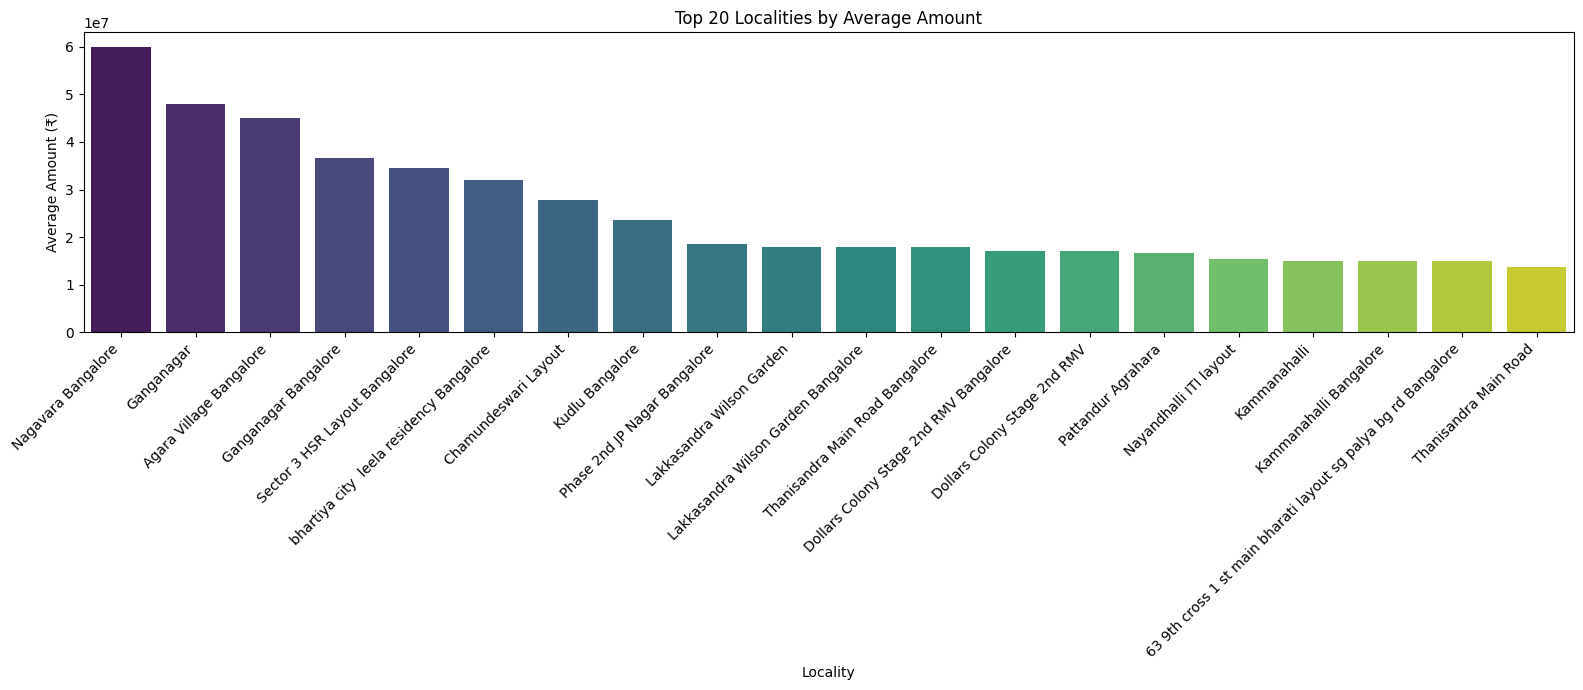

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get mean values
means = df.groupby("Locality")[["Amount", "Area_sqft"]].mean().sort_values(by="Amount", ascending=False).reset_index().head(20)


# Seaborn barplot
plt.figure(figsize=(16,7))
sns.barplot( x=means["Locality"], y=means["Amount"], palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Localities by Average Amount")
plt.xlabel("Locality")
plt.ylabel("Average Amount (₹)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4278977131.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x=means["Locality"], y=means["Area_sqft"], palette="viridis")


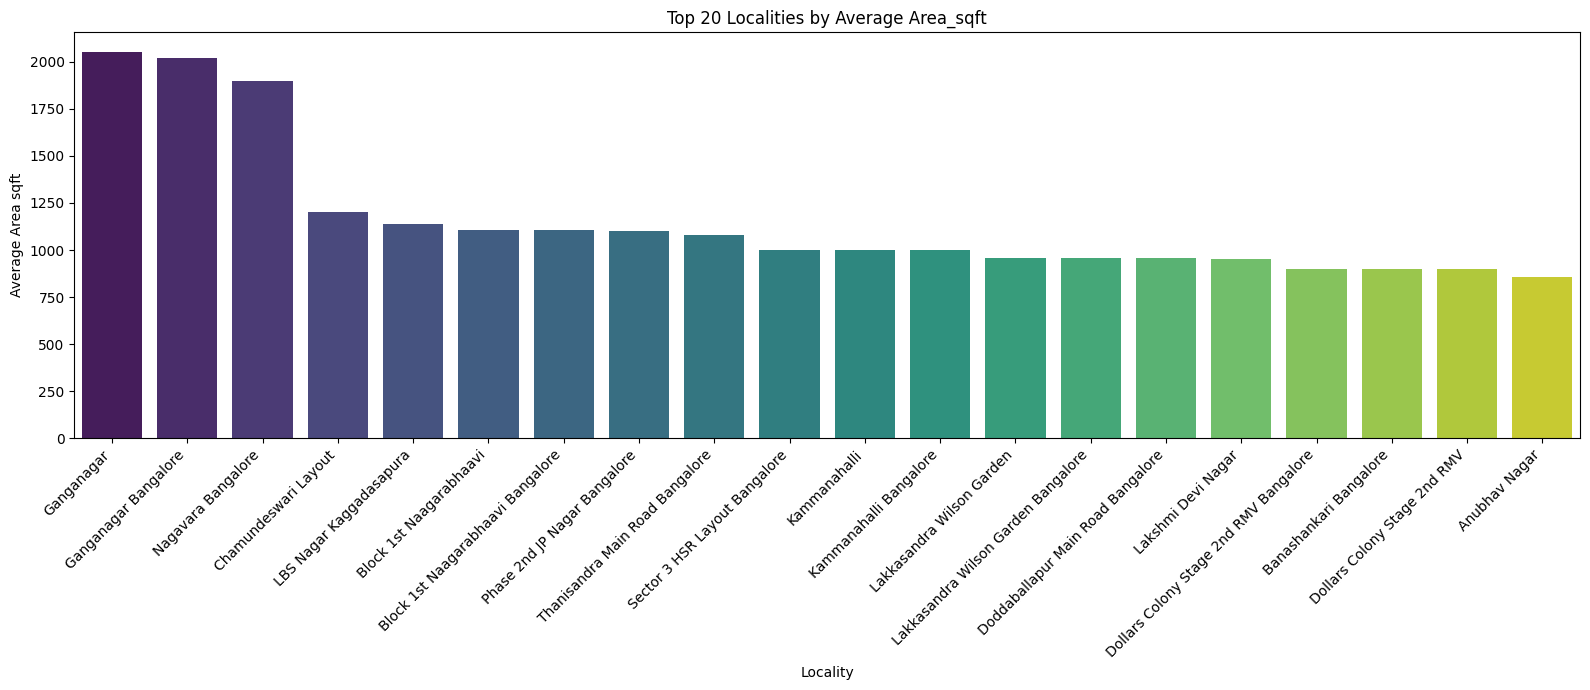

In [206]:
means = df.groupby("Locality")[["Amount", "Area_sqft"]].mean().sort_values(by="Area_sqft", ascending=False).reset_index().head(20)


# Seaborn barplot
plt.figure(figsize=(16,7))
sns.barplot( x=means["Locality"], y=means["Area_sqft"], palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Localities by Average Area_sqft")
plt.xlabel("Locality")
plt.ylabel("Average Area sqft")
plt.tight_layout()
plt.show()

### Correlation between Amount and Area_sqft

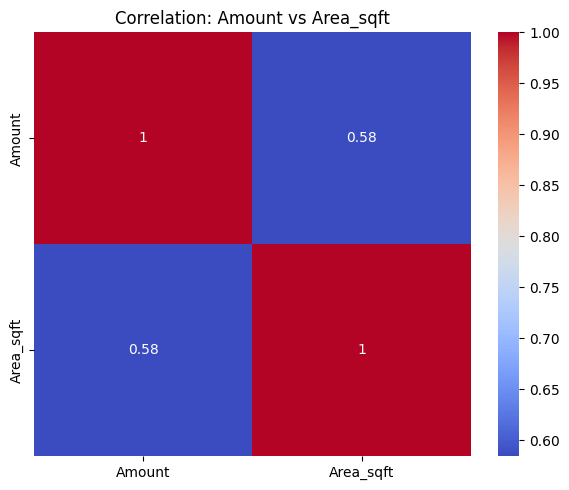

In [210]:

correlation = df[["Amount", "Area_sqft"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation: Amount vs Area_sqft")
plt.tight_layout()
plt.show()

### Mean values by Locality

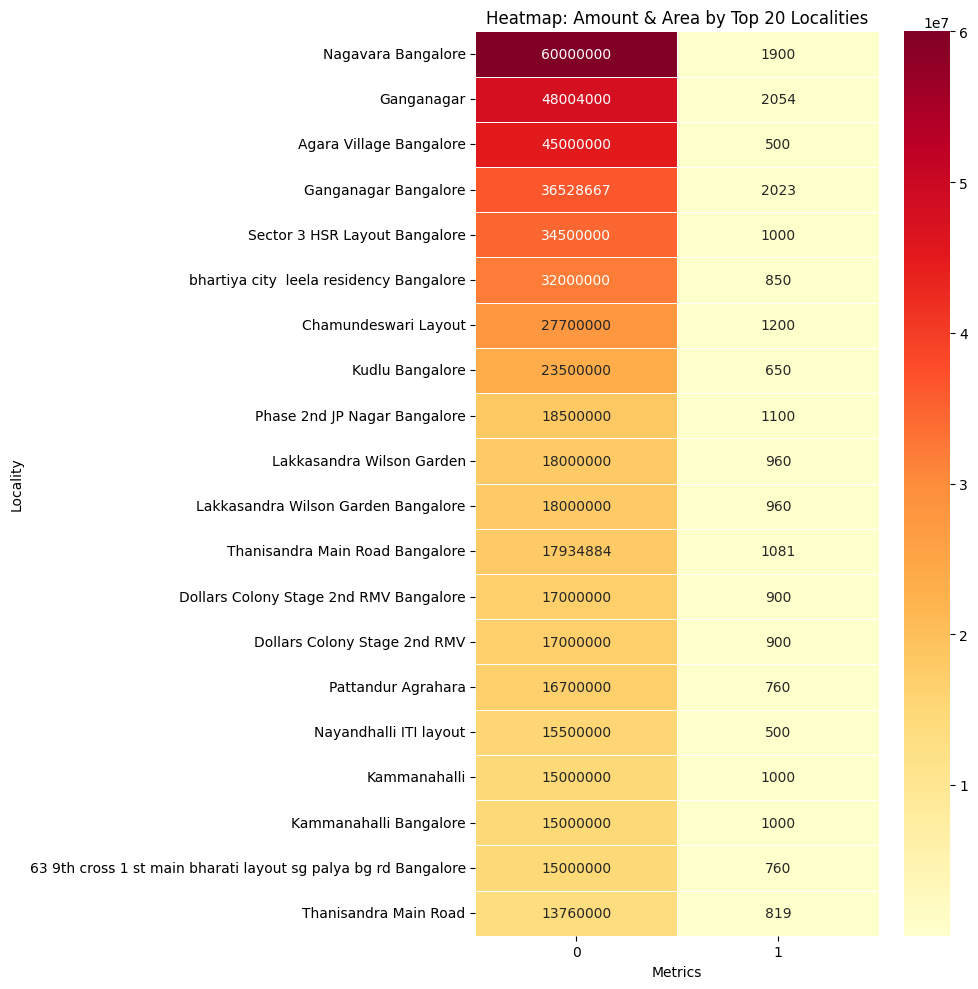

In [209]:

locality_means = df.groupby("Locality")[["Amount", "Area_sqft"]].mean().sort_values(by="Amount", ascending=False).head(20)

# Create heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(locality_means.values, annot=True, fmt='.0f', cmap="YlOrRd", linewidths=0.5, yticklabels=locality_means.index)
plt.title("Heatmap: Amount & Area by Top 20 Localities")
plt.ylabel("Locality")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()

# 🏠 MagicBricks Real Estate Web Scraping & Visualization Project

**📅 Created on:** 2025-11-02  
**👨‍💻 Author:** Sourav Mondal

---

## 📘 Project Overview

This project demonstrates **end-to-end web scraping, cleaning, and visualization** of property listings from [**MagicBricks**](https://www.magicbricks.com).

It uses **Selenium** for browser automation, **BeautifulSoup** for HTML parsing, **Pandas** for data cleaning, and **Matplotlib/Seaborn** for visualization.

The notebook automates browser scrolling, scrapes multiple pages, extracts property details (price, title, location, etc.), cleans and saves data to Excel/CSV, and visualizes key insights like **price distribution**, **price vs. area**, and **top localities**.

---

## 🧠 Tech Stack & Libraries Used

- **selenium** - Browser automation and dynamic page handling
- **webdriver-manager** - Auto-handling of ChromeDriver
- **beautifulsoup4** - Parsing HTML content
- **pandas** - Data cleaning and analysis
- **matplotlib** - Static visualizations
- **seaborn** - Statistical visualizations
- **numpy** - Numerical operations
- **time** - Handling dynamic waits

---

## ⚙️ Installation & Setup

Run these commands in your environment or notebook before execution:
```bash
pip install selenium webdriver-manager beautifulsoup4 pandas matplotlib seaborn numpy
```

---

## 🚀 Workflow Summary

1. **Set Up WebDriver:** Initialize Selenium with Chrome in headless mode
2. **Scrape Listings:** Automate scrolling, pagination, and card extraction
3. **Extract Data:** Parse titles, prices, locations, details, and URLs using BeautifulSoup
4. **Clean Data:** Remove duplicates, convert price/area to numeric, handle missing values
5. **Store Output:** Save cleaned data to CSV and Excel files
6. **Visualize Insights:** Use Matplotlib & Seaborn for trend and distribution charts

---

## 📁 Project Structure
```
MagicBricks_WebScraping/
│
├── Magicbricks_webscrapping.ipynb   # Main notebook file
├── magicbricks_data.csv             # Cleaned data (output)
├── 1bhk_bengalore.xlsx             # Excel version of output
├── README.md                        # This file
└── requirements.txt                 # Dependencies (optional)
```

---

## 🧹 Data Cleaning Process

- Removed unwanted text symbols like ₹, commas, and unit words
- Converted price and area to numeric using regex extraction
- Trimmed whitespace and standardized text case
- Handled missing values and duplicates

---

## 💾 Data Output Schema

**Column Descriptions:**

- **Title** - Property title or headline
- **Price** - Listed price (string)
- **Price_num** - Numeric price value (converted)
- **Location** - Area / neighborhood
- **Details** - BHK, size, furnishing, etc.
- **URL** - Direct property listing link
- **Scraped_at** - Timestamp of data collection

---

## 🧾 Insights Gained

- Larger area properties tend to show an exponential increase in price
- Median prices vary drastically between localities like **Whitefield**, **Indiranagar**, and **Koramangala**
- Price distribution is **right-skewed** — most listings fall within affordable/mid-range, with a few luxury outliers
- Log-scaling reveals a smoother normal distribution of property values

---

## 💡 Future Enhancements

- Add **BHK-level segmentation** (e.g., 1BHK vs 3BHK)
- Integrate **geolocation mapping** using Folium or Plotly Mapbox
- Automate daily scrapes with scheduling (cron / Airflow)
- Push data to **MySQL or MongoDB** for long-term tracking
- Deploy a **Streamlit dashboard** for real-time visualization

---

## ⚠️ Ethical & Legal Notice

This project is for **educational and research purposes only.**

Always comply with MagicBricks' **Terms of Service** and **robots.txt** before scraping.

Avoid aggressive scraping (use reasonable delays, limited pages).

---

## 🧑‍💻 Author Information

**Sourav Mondal**

📧 souravmondal5f@gmail.com

🔗 [LinkedIn Profile](https://www.linkedin.com/in/sourav-mondal-7991b5373/)

---

## 📄 License

This project is open source and available for educational purposes.

---

